## Introduction

L'objectif de ce notebook est d'exposer notre démarche dans la recherche de notre modèle dans le cadre de la prédiction du métier d'un individu selon son CV. Nous avons essayé de comparer différentes méthodes d'apprentissage afin d'avoir le meilleur modèle tout en prennat en compte deux métriques: le f1_score et le score de disparité démographique (disparate impact) moyen.

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time

In [2]:
# Ce dictionnaire nous servira à construire notre tablea récapituliatif de résultats obtenus à la fin de ce notebook.
summary = {}

In [3]:
#Read our pre-cleaned data from our first round of cleaning

data1 = pd.read_pickle("../../Project_outputs/pickled_files/corpus/round2_cleaned_corpus_for_models.pkl")
# data = data.transpose()
data1.head()

Id                                        description gender  categories
0   0  also ronald asmus policy entrepreneur fellow g...      F   professor
1   1  member aicpa wicpa brent graduate university w...      M  accountant
2   2  dr aster hold teach research position ben guri...      M   professor
4   3  run boutique design studio attend clients unit...      M   architect
5   4  focus cloud security identity access managemen...      M   architect

## Classification en utilisant la lemmatisation sur les données

In [4]:
# Scindons les données:
features = data1.description

#viriable que l'on souhaite prédire
labels1 = data1.categories

In [5]:
jobs = list(labels1.unique())

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels1, data1.index, test_size=0.33, random_state=0)

In [7]:
X_train

161948    publish paper presentism possibility junk hist...
147893    primary research interest focus theoretical al...
113918    graduate honor years diverse experience especi...
111252    residentexecutive editor jang group news inter...
241051    also behavior management coordinator mentor se...
                                ...                        
221542    ms west begin career corporate attorney ten ye...
147555    successfully couple business acumen exposure p...
217453    broad interest laparoscopic colon surgery colo...
54411     receive ba wellesley college phd economics pri...
249381    unique style characterize creation large scale...
Name: description, Length: 145454, dtype: object

In [8]:
X_test

236912    join fletcher sippel stephen litigate personal...
5595      complete robert wood johnson clinical scholars...
4495      february carr begin feel ill think may injure ...
32989     cloud state university teach specialty geriatr...
92688     clinical interest include musculoskeletal neur...
                                ...                        
164515    graduate honor years diverse experience especi...
45019     manage partner head assurance practice extensi...
226022    director data concentration program journalism...
65705     research interest include teacher wellbeing cu...
190387    cinematic ode new york knicks porzingod star j...
Name: description, Length: 71643, dtype: object

In [9]:
indices_train

Int64Index([161948, 147893, 113918, 111252, 241051,  27930, 203075, 253905,
            240492, 222885,
            ...
            153364,  52430, 122154, 120002, 190689, 221542, 147555, 217453,
             54411, 249381],
           dtype='int64', length=145454)

In [10]:
print(type(indices_test))
indices_test


<class 'pandas.core.indexes.numeric.Int64Index'>


Int64Index([236912,   5595,   4495,  32989,  92688,  75392, 117226, 103618,
            183041, 218912,
            ...
            228243, 152477, 122702, 227420, 238260, 164515,  45019, 226022,
             65705, 190387],
           dtype='int64', length=71643)

In [11]:
X_test_save = X_test

In [12]:
tfidf_vect1 = TfidfVectorizer(max_features=20000, sublinear_tf=True, min_df=5, norm='l2')

In [13]:
tfidf_vect1.fit(X_train)

TfidfVectorizer(max_features=20000, min_df=5, sublinear_tf=True)

In [14]:
import pickle
import os

filename = "../../Project_outputs/pickled_files/vectorizer/round2_tfidf_vect.pkl"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'wb') as f:
    pickle.dump(tfidf_vect1, f)

In [15]:
X_train = tfidf_vect1.transform(X_train)
X_train

<145454x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 4283066 stored elements in Compressed Sparse Row format>

In [16]:
X_test = tfidf_vect1.transform(X_test)
X_test

<71643x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 2102747 stored elements in Compressed Sparse Row format>

## Sélection du modèle

Ici, nous allons tenté différents modèles et évaluer leur f1-score.

Les modèles que nous allons tester sont:
- Logistic Regression 
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
logreg1 = LogisticRegression(random_state=0, max_iter=2000, multi_class='multinomial')

In [19]:
tps0=time.perf_counter()

logreg1.fit(X_train, y_train)

tps1=(time.perf_counter()-tps0)

print(f"temps d'entrainement: {tps1}")

temps d'entrainement: 183.802625066


In [20]:
import pickle
filename = "../../Project_outputs/pickled_files/models/log_reg/model_2_trained_with_round2_cleaned_corpus_for_models.pkl"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
pickle.dump(logreg1, open(filename, 'wb'))

In [21]:
y_pred_logreg1 = logreg1.predict(X_test)
y_pred_logreg1

array(['attorney', 'professor', 'filmmaker', ..., 'journalist',
       'professor', 'filmmaker'], dtype=object)

In [22]:
print('accuracy %s' % accuracy_score(y_pred_logreg1, y_test))
print(classification_report(y_test, y_pred_logreg1,target_names=jobs))

accuracy 0.7931130745502003
                   precision    recall  f1-score   support

        professor       0.86      0.65      0.74      1050
       accountant       0.71      0.60      0.65      1918
        architect       0.84      0.89      0.86      6236
     psychologist       0.91      0.52      0.66       467
       journalist       0.85      0.64      0.73       566
          teacher       0.80      0.78      0.79      1161
            nurse       0.95      0.91      0.93      1790
         attorney       0.84      0.76      0.80       750
software_engineer       0.91      0.58      0.71       297
          painter       0.81      0.74      0.77      1344
        physician       0.81      0.50      0.62       282
     chiropractor       0.64      0.77      0.70      4085
 personal_trainer       0.81      0.73      0.77      1397
     photographer       0.88      0.81      0.84      4134
          surgeon       0.82      0.77      0.79      1463
        filmmaker       0.9

In [23]:
logreg1_f1_score = f1_score(y_test, y_pred_logreg1, average='macro')
print('f1_score: %s' % logreg1_f1_score)

f1_score: 0.7279625670077278


In [24]:
cross_logreg1 = pd.crosstab(y_pred_logreg1, y_test, rownames=['Predicted job'], colnames=['Actual job'])
cross_logreg1

Actual job         accountant  architect  attorney  chiropractor  comedian  \
Predicted job                                                                
accountant                686          9        26             0         1   
architect                  18       1142        10             0         2   
attorney                   97         41      5524             8        15   
chiropractor                0          0         1           245         0   
comedian                    2          1         2             0       362   
composer                    0          4         6             0         4   
dentist                     0          0         1             4         0   
dietitian                   0          0         4             2         1   
dj                          0          2         0             0         0   
filmmaker                   1          3        11             1        16   
interior_designer           0         20         0             0         0   
journalist                 44         52       144             7        77   
model                       4          8        10             0        29   
nurse                       5          2        20            17         0   
painter                     1         15         3             0         3   
paralegal                   0          0         6             0         0   
pastor                      5          2         9             0         2   
personal_trainer            0          0         1             2         0   
photographer               17         61        21             3        15   
physician                   5          1         5           119         0   
poet                        1          4         4             1         0   
professor                 102        300       322            24        10   
psychologist                5          3        24            10         6   
rapper                      0          0         0             0         0   
software_engineer           5        208         5             0         1   
surgeon                     0          0         2            14         0   
teacher                    52         40        74             8        22   
yoga_teacher                0          0         1             2         0   

Actual job         composer  dentist  dietitian   dj  filmmaker  ...  \
Predicted job                                                    ...   
accountant                0        6          0    1          0  ...   
architect                 4        3          0    3          1  ...   
attorney                  3       12          5    1         13  ...   
chiropractor              0        0          0    0          0  ...   
comedian                  2        0          0    1          7  ...   
composer                904        1          0   29         13  ...   
dentist                   0     1627          0    0          0  ...   
dietitian                 0        1        568    0          0  ...   
dj                        1        0          0  172          1  ...   
filmmaker                25        1          0    1        996  ...   
interior_designer         0        0          0    0          0  ...   
journalist               24        8         24   33         96  ...   
model                     4        3          0    4         13  ...   
nurse                     0        9         14    0          0  ...   
painter                   5        1          1    1          9  ...   
paralegal                 0        0          0    0          0  ...   
pastor                    2        1          0    0          0  ...   
personal_trainer          0        1          8    0          0  ...   
photographer             27        6          6   21         85  ...   
physician                 1       25         20    0          0  ...   
poet                     15        0          0    0          3  ...   
pro

In [25]:
import seaborn as sns

def plot_heatmap(cross_table, y_label, x_label, fmt='g'):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cross_table,
                annot=None,
                fmt=fmt,
                cmap='magma_r',
                linewidths=.5,
                ax=ax)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()


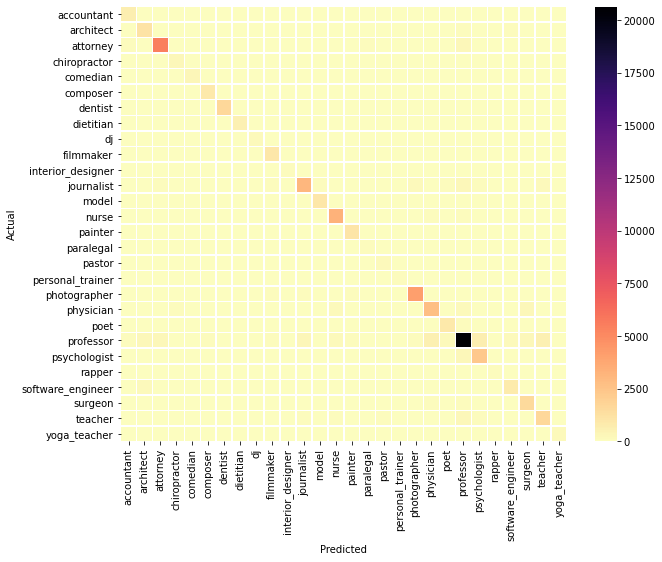

In [26]:
plot_heatmap(cross_logreg1, 'Actual', 'Predicted', fmt='.2%')

In [27]:
y_pred_proba_logreg1 = logreg1.predict_proba(X_test)
y_pred_proba_logreg1

array([[2.79086430e-03, 7.93917845e-04, 9.25071599e-01, ...,
        2.62002493e-03, 5.51123926e-03, 2.39180724e-04],
       [4.34524654e-05, 5.97979076e-05, 5.66093764e-04, ...,
        1.15914246e-03, 2.62505414e-04, 4.22276449e-05],
       [6.63266074e-03, 5.15012283e-03, 1.22921869e-02, ...,
        3.21126560e-02, 6.64579032e-02, 5.27933316e-02],
       ...,
       [2.13263210e-03, 9.55797515e-03, 1.13914221e-02, ...,
        1.48479799e-03, 1.19375629e-02, 2.49398838e-04],
       [1.70264753e-05, 1.17377029e-04, 3.69837231e-05, ...,
        3.18498775e-05, 4.72359550e-02, 6.48808921e-05],
       [6.81052327e-04, 8.18911553e-04, 2.03124504e-03, ...,
        4.83623034e-04, 3.38119293e-03, 2.59337108e-04]])

In [28]:
y_pred_proba_logreg1.shape

(71643, 28)

In [29]:
print("---Tableau de probabilités de prédiction d'appartenance du premier CV de test aux différents métiers: ")
y_pred_proba_logreg1[1]

---Tableau de probabilités de prédiction d'appartenance du premier CV de test aux différents métiers: 


array([4.34524654e-05, 5.97979076e-05, 5.66093764e-04, 6.41984987e-05,
       1.90649598e-05, 3.84780814e-05, 1.10402600e-04, 9.37342827e-04,
       1.70000896e-05, 5.71949911e-05, 2.57134641e-05, 2.92513000e-04,
       2.90679210e-05, 3.06321243e-03, 3.84919837e-05, 7.78455914e-05,
       4.63457022e-05, 1.45225569e-04, 3.48477867e-05, 2.89628506e-02,
       4.79291715e-05, 9.62287084e-01, 1.43796476e-03, 1.54843769e-05,
       1.18521788e-04, 1.15914246e-03, 2.62505414e-04, 4.22276449e-05])

In [30]:
log_reg_pred_prob1 = pd.DataFrame(y_pred_proba_logreg1, columns=logreg1.classes_)
log_reg_pred_prob1.head()

accountant  architect  attorney  chiropractor  comedian  composer  \
0    0.002791   0.000794  0.925072      0.000426  0.000805  0.000803   
1    0.000043   0.000060  0.000566      0.000064  0.000019  0.000038   
2    0.006633   0.005150  0.012292      0.007217  0.033956  0.011899   
3    0.000559   0.010157  0.003290      0.001165  0.000389  0.000508   
4    0.009566   0.008364  0.010951      0.015897  0.004251  0.008599   

    dentist  dietitian        dj  filmmaker  ...  photographer  physician  \
0  0.000486   0.000513  0.000303   0.000778  ...      0.001543   0.002342   
1  0.000110   0.000937  0.000017   0.000057  ...      0.000035   0.028963   
2  0.005250   0.008893  0.007207   0.366423  ...      0.045782   0.035547   
3  0.000613   0.000936  0.000226   0.000513  ...      0.001553   0.004964   
4  0.004359   0.004186  0.003176   0.006703  ...      0.011435   0.188768   

       poet  professor  psychologist    rapper  software_engineer   surgeon  \
0  0.001356   0.035947      0.002055  0.000347           0.001366  0.002620   
1  0.000048   0.962287      0.001438  0.000015           0.000119  0.001159   
2  0.024843   0.010642      0.036079  0.008642           0.004754  0.032113   
3  0.002420   0.693397      0.003282  0.000293           0.000853  0.001604   
4  0.010469   0.427068      0.032239  0.003878           0.010513  0.113212   

    teacher  yoga_teacher  
0  0.005511      0.000239  
1  0.000263      0.000042  
2  0.066458      0.052793  
3  0.075077      0.001804  
4  0.014529      0.002507  

[5 rows x 28 columns]

In [31]:
y_pred_logreg_df1 = pd.DataFrame(y_pred_logreg1, columns=['predicted_job'])
y_pred_logreg_df1.head()

predicted_job
0      attorney
1     professor
2     filmmaker
3     professor
4     professor

In [32]:
log_reg_pred_prob1 = pd.concat([log_reg_pred_prob1, y_pred_logreg_df1], axis=1)
log_reg_pred_prob1.head()

accountant  architect  attorney  chiropractor  comedian  composer  \
0    0.002791   0.000794  0.925072      0.000426  0.000805  0.000803   
1    0.000043   0.000060  0.000566      0.000064  0.000019  0.000038   
2    0.006633   0.005150  0.012292      0.007217  0.033956  0.011899   
3    0.000559   0.010157  0.003290      0.001165  0.000389  0.000508   
4    0.009566   0.008364  0.010951      0.015897  0.004251  0.008599   

    dentist  dietitian        dj  filmmaker  ...  physician      poet  \
0  0.000486   0.000513  0.000303   0.000778  ...   0.002342  0.001356   
1  0.000110   0.000937  0.000017   0.000057  ...   0.028963  0.000048   
2  0.005250   0.008893  0.007207   0.366423  ...   0.035547  0.024843   
3  0.000613   0.000936  0.000226   0.000513  ...   0.004964  0.002420   
4  0.004359   0.004186  0.003176   0.006703  ...   0.188768  0.010469   

   professor  psychologist    rapper  software_engineer   surgeon   teacher  \
0   0.035947      0.002055  0.000347           0.001366  0.002620  0.005511   
1   0.962287      0.001438  0.000015           0.000119  0.001159  0.000263   
2   0.010642      0.036079  0.008642           0.004754  0.032113  0.066458   
3   0.693397      0.003282  0.000293           0.000853  0.001604  0.075077   
4   0.427068      0.032239  0.003878           0.010513  0.113212  0.014529   

   yoga_teacher  predicted_job  
0      0.000239       attorney  
1      0.000042      professor  
2      0.052793      filmmaker  
3      0.001804      professor  
4      0.002507      professor  

[5 rows x 29 columns]

In [33]:
print("Extraction des 50 premiers CV")
log_reg_pred_prob_ext1 = log_reg_pred_prob1.iloc[:50]
log_reg_pred_prob_ext1.head()

Extraction des 50 premiers CV


accountant  architect  attorney  chiropractor  comedian  composer  \
0    0.002791   0.000794  0.925072      0.000426  0.000805  0.000803   
1    0.000043   0.000060  0.000566      0.000064  0.000019  0.000038   
2    0.006633   0.005150  0.012292      0.007217  0.033956  0.011899   
3    0.000559   0.010157  0.003290      0.001165  0.000389  0.000508   
4    0.009566   0.008364  0.010951      0.015897  0.004251  0.008599   

    dentist  dietitian        dj  filmmaker  ...  physician      poet  \
0  0.000486   0.000513  0.000303   0.000778  ...   0.002342  0.001356   
1  0.000110   0.000937  0.000017   0.000057  ...   0.028963  0.000048   
2  0.005250   0.008893  0.007207   0.366423  ...   0.035547  0.024843   
3  0.000613   0.000936  0.000226   0.000513  ...   0.004964  0.002420   
4  0.004359   0.004186  0.003176   0.006703  ...   0.188768  0.010469   

   professor  psychologist    rapper  software_engineer   surgeon   teacher  \
0   0.035947      0.002055  0.000347           0.001366  0.002620  0.005511   
1   0.962287      0.001438  0.000015           0.000119  0.001159  0.000263   
2   0.010642      0.036079  0.008642           0.004754  0.032113  0.066458   
3   0.693397      0.003282  0.000293           0.000853  0.001604  0.075077   
4   0.427068      0.032239  0.003878           0.010513  0.113212  0.014529   

   yoga_teacher  predicted_job  
0      0.000239       attorney  
1      0.000042      professor  
2      0.052793      filmmaker  
3      0.001804      professor  
4      0.002507      professor  

[5 rows x 29 columns]

In [34]:
log_reg_pred_prob_ext1_T = log_reg_pred_prob_ext1.transpose()
log_reg_pred_prob_ext1_T.head()

0            1           2            3           4   \
accountant     0.00279086  4.34525e-05  0.00663266  0.000558577  0.00956581   
architect     0.000793918  5.97979e-05  0.00515012    0.0101572  0.00836383   
attorney         0.925072  0.000566094   0.0122922   0.00328961   0.0109507   
chiropractor  0.000426414  6.41985e-05  0.00721659   0.00116529    0.015897   
comedian      0.000805173   1.9065e-05   0.0339559  0.000389112  0.00425137   

                      5            6            7            8            9   \
accountant     0.0131218  0.000204124  1.86458e-05   0.00185262  0.000133849   
architect       0.075044   0.00113012  9.51696e-05   0.00372295  0.000427933   
attorney       0.0256918  0.000226391  0.000314264   0.00339234     0.120644   
chiropractor  0.00710071  5.93566e-05  3.81238e-05  0.000820368  6.05748e-05   
comedian       0.0313716  8.56233e-05  3.02961e-05  0.000245855  4.63236e-05   

              ...           40           41          42           43  \
accountant    ...  1.01554e-05  5.14555e-05   0.0129823   0.00660381   
architect     ...  8.37239e-06  4.14186e-05  0.00603752   0.00443035   
attorney      ...  1.62492e-05  0.000573736   0.0465561     0.729174   
chiropractor  ...  7.38411e-06  0.000994128  0.00269168  0.000813393   
comedian      ...  2.17005e-06    3.318e-05   0.0057055   0.00174441   

                       44           45           46           47          48  \
accountant    0.000508095   0.00114778   0.00130142   0.00229323   0.0181802   
architect     0.000435024   0.00165013   0.00166962   0.00213072  0.00871286   
attorney      0.000482465  0.000507556    0.0025014   0.00531833   0.0841935   
chiropractor  0.000205971   0.00026909   0.00289816  0.000439983  0.00244259   
comedian      0.000221532  0.000296312  0.000937601  0.000411081   0.0144132   

                      49  
accountant    0.00784925  
architect     0.00971847  
attorney       0.0441007  
chiropractor  0.00600559  
comedian      0.00171368  

[5 rows x 50 columns]

In [35]:
log_reg_pred_prob_ext1_T.rename(columns=lambda x: f"cv_{x}", inplace=True)
log_reg_pred_prob_ext1_T.head()

cv_0         cv_1        cv_2         cv_3        cv_4  \
accountant     0.00279086  4.34525e-05  0.00663266  0.000558577  0.00956581   
architect     0.000793918  5.97979e-05  0.00515012    0.0101572  0.00836383   
attorney         0.925072  0.000566094   0.0122922   0.00328961   0.0109507   
chiropractor  0.000426414  6.41985e-05  0.00721659   0.00116529    0.015897   
comedian      0.000805173   1.9065e-05   0.0339559  0.000389112  0.00425137   

                    cv_5         cv_6         cv_7         cv_8         cv_9  \
accountant     0.0131218  0.000204124  1.86458e-05   0.00185262  0.000133849   
architect       0.075044   0.00113012  9.51696e-05   0.00372295  0.000427933   
attorney       0.0256918  0.000226391  0.000314264   0.00339234     0.120644   
chiropractor  0.00710071  5.93566e-05  3.81238e-05  0.000820368  6.05748e-05   
comedian       0.0313716  8.56233e-05  3.02961e-05  0.000245855  4.63236e-05   

              ...        cv_40        cv_41       cv_42        cv_43  \
accountant    ...  1.01554e-05  5.14555e-05   0.0129823   0.00660381   
architect     ...  8.37239e-06  4.14186e-05  0.00603752   0.00443035   
attorney      ...  1.62492e-05  0.000573736   0.0465561     0.729174   
chiropractor  ...  7.38411e-06  0.000994128  0.00269168  0.000813393   
comedian      ...  2.17005e-06    3.318e-05   0.0057055   0.00174441   

                    cv_44        cv_45        cv_46        cv_47       cv_48  \
accountant    0.000508095   0.00114778   0.00130142   0.00229323   0.0181802   
architect     0.000435024   0.00165013   0.00166962   0.00213072  0.00871286   
attorney      0.000482465  0.000507556    0.0025014   0.00531833   0.0841935   
chiropractor  0.000205971   0.00026909   0.00289816  0.000439983  0.00244259   
comedian      0.000221532  0.000296312  0.000937601  0.000411081   0.0144132   

                   cv_49  
accountant    0.00784925  
architect     0.00971847  
attorney       0.0441007  
chiropractor  0.00600559  
comedian      0.00171368  

[5 rows x 50 columns]

In [36]:
log_reg_pred_prob_ext1_T

cv_0         cv_1        cv_2         cv_3  \
accountant          0.00279086  4.34525e-05  0.00663266  0.000558577   
architect          0.000793918  5.97979e-05  0.00515012    0.0101572   
attorney              0.925072  0.000566094   0.0122922   0.00328961   
chiropractor       0.000426414  6.41985e-05  0.00721659   0.00116529   
comedian           0.000805173   1.9065e-05   0.0339559  0.000389112   
composer           0.000803232  3.84781e-05   0.0118989  0.000508133   
dentist            0.000485711  0.000110403  0.00524957  0.000613278   
dietitian          0.000512718  0.000937343  0.00889313  0.000935526   
dj                 0.000303095  1.70001e-05  0.00720674  0.000225735   
filmmaker          0.000777849   5.7195e-05    0.366423  0.000513205   
interior_designer   0.00022844  2.57135e-05  0.00340355  0.000444068   
journalist          0.00231304  0.000292513   0.0320469  0.000542848   
model              0.000856042  2.90679e-05   0.0351514  0.000576608   
nurse               0.00297271   0.00306321    0.111985     0.190795   
painter            0.000756565   3.8492e-05   0.0175364   0.00146871   
paralegal           0.00522003  7.78456e-05  0.00208425   0.00074408   
pastor             0.000966156  4.63457e-05  0.00987072    0.0011099   
personal_trainer   0.000590995  0.000145226  0.00535238  0.000716484   
photographer        0.00154325  3.48478e-05   0.0457816   0.00155317   
physician             0.002342    0.0289629   0.0355472   0.00496414   
poet                0.00135554  4.79292e-05   0.0248426   0.00241954   
professor            0.0359467     0.962287   0.0106415     0.693397   
psychologist        0.00205451   0.00143796   0.0360788   0.00328226   
rapper             0.000346988  1.54844e-05  0.00864175  0.000293449   
software_engineer   0.00136598  0.000118522  0.00475367  0.000852531   
surgeon             0.00262002   0.00115914   0.0321127   0.00160425   
teacher             0.00551124  0.000262505   0.0664579     0.075077   
yoga_teacher       0.000239181  4.22276e-05   0.0527933   0.00180364   
predicted_job         attorney    professor   filmmaker    professor   

                         cv_4          cv_5         cv_6         cv_7  \
accountant         0.00956581     0.0131218  0.000204124  1.86458e-05   
architect          0.00836383      0.075044   0.00113012  9.51696e-05   
attorney            0.0109507     0.0256918  0.000226391  0.000314264   
chiropractor         0.015897    0.00710071  5.93566e-05  3.81238e-05   
comedian           0.00425137     0.0313716  8.56233e-05  3.02961e-05   
composer           0.00859928     0.0432673  0.000122002   2.3607e-05   
dentist             0.0043593     0.0108696  8.12046e-05  0.000145577   
dietitian          0.00418579        0.0127  7.44154e-05  3.24861e-05   
dj                 0.00317564     0.0121037  5.50081e-05  1.42806e-05   
filmmaker          0.00670276      0.037902  0.000108382  2.78223e-05   
interior_designer  0.00289355     0.0136745  5.17732e-05  2.54837e-05   
journalist          0.0170546       0.11071  0.000485695   0.00042509   
model               0.0103115     0.0314041  0.000717238  1.70416e-05   
nurse               0.0555631     0.0207194  0.000107892  5.31686e-05   
painter             0.0067649     0.0437495  0.000219068  3.72368e-05   
paralegal          0.00381456    0.00543614   8.0317e-05  2.18998e-05   
pastor             0.00458303     0.0122019  9.26043e-05  3.43576e-05   
personal_trainer   0.00834453    0.00580628  4.61345e-05  9.72626e-06   
photographer        0.0114351      0.174938    0.0014266   0.00014124   
physician            0.188768     0.0262553  0.000492161  0.000596823   
poet                0.0104686     0.0710516  0.000221438  0.000120856   
professor            0.427068     0.0354258     0.991689     0.996194   
psychologist        0.0322393     0.0326285   0.00116093   0.00120802   
rapper             0.00387843      0.013493  6.04056e-05  1.57741e-05   
software_engineer   0.0105129     0.0161

In [37]:
filename = "../../Project_outputs/json_files/exported_log_reg_2_pred_results.json"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
log_reg_pred_prob_ext1_T.to_json(filename, indent=4)

In [38]:
filename = "../../Project_outputs/csv_files/exported_log_reg_2_pred_results.csv"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
log_reg_pred_prob_ext1_T.to_csv(filename, index=True,header=True)

#### Disparate impact

In [39]:
def dispImpContTable(y_test, y_pred, data):
    
    # Cette fonction nous permet de construire une table de contingence 
    # croisant les métiers prédits par notre modèle et le genre de l'individu correspondant.
    # La table nous construite nous aidera à calculer le disparate impact moyen. 
    # Cette métrique nous servira à évaluer le niveau de loyauté de notre modèle suivant le genre

    #print("---------------------------------")
    y_test_reset_index = y_test.reset_index()
    y_test_reset_index.rename(columns={"categories":"actual_job"}, inplace=True)
    #print(y_test_reset_index.head())
    #print(" ")

    y_pred_df = pd.DataFrame(y_pred, columns=['predicted_job'])
    #print(y_pred_df.head())
    #print(" ")

    y_concat_test_pred = pd.concat([y_test_reset_index, y_pred_df], axis=1)
    #print(y_concat_test_pred.head())
    #print(" ")

    data_bis = data.reset_index()
    #print(data_bis.head())
    #print(" ")

    y_final = pd.merge(y_concat_test_pred, data_bis, on=["index"])
    #print(y_final.head())
    #print(" ")

    y_final.drop(columns=["description", "categories", "Id"], inplace=True)
    #print(y_final.head())
    #print(" ")

    cross = pd.crosstab(y_final['predicted_job'], y_final['gender'], rownames=['predicted_job'], colnames=['gender'])
    #print(cross.head())
    #print("---------------------------------")
    return cross

In [40]:
def DI(tab):
    """
    Calcule le disparate impact ponctuel d'une table de contingence 
    Colonnes = Variable sensible
    Lignes = variable cible
    """
    print('**************************************')
    print(tab)
    print('**************************************')
    tab_np = tab.to_numpy()
    DI = (tab_np[1,0] / (tab_np[1,0] + tab_np[0,0])) / (tab_np[1,1] / (tab_np[1,1] + tab_np[0,1]))
    return DI

In [41]:
logreg1_crossDispImp = dispImpContTable(y_test, y_pred_logreg1, data1)
logreg1_crossDispImp

gender                 F      M
predicted_job                  
accountant           277    520
architect            410   1189
attorney            2530   4020
chiropractor          63    207
comedian             105    320
composer             200    925
dentist              617   1099
dietitian            625     49
dj                    23    165
filmmaker            383    850
interior_designer    131     43
journalist          2286   2618
model               1041    213
nurse               3413    355
painter              681    689
paralegal            113     24
pastor               100    259
personal_trainer      83     91
photographer        1973   3196
physician           1467   2205
poet                 633    599
professor          11103  14126
psychologist        1894   1132
rapper                14    163
software_engineer    148    997
surgeon              282   1603
teacher             1793   1313
yoga_teacher         241     44

In [42]:
from statistics import mean

def avgDi(cross):
    listDi = []
    index = cross.index
    for job in index:
        print("--------------------------------")
        print(f"job: {job}")
        actual = cross[index == job]
        others = cross[index != job]
        others_sum = cross.sum(axis=0).to_frame(name="others").T
        concat = pd.concat([others_sum, actual])
        print("corresponding crosstab:")
        di = DI(concat)
        print("")
        print(f"disparate impact of {job}: {di}")
        listDi.append(di)
    print(" ")
    print(listDi)
    return mean(listDi)

In [43]:
logreg1_avgDi = avgDi(logreg1_crossDispImp)

--------------------------------
job: accountant
corresponding crosstab:
**************************************
gender          F      M
others      32629  39014
accountant    277    520
**************************************

disparate impact of accountant: 0.6399883818242172
--------------------------------
job: architect
corresponding crosstab:
**************************************
gender         F      M
others     32629  39014
architect    410   1189
**************************************

disparate impact of architect: 0.4195981551583239
--------------------------------
job: attorney
corresponding crosstab:
**************************************
gender        F      M
others    32629  39014
attorney   2530   4020
**************************************

disparate impact of attorney: 0.7703173316839677
--------------------------------
job: chiropractor
corresponding crosstab:
**************************************
gender            F      M
others        32629  39014
chiropractor 

In [44]:
print(f"Le disparate impact moyen associé à ce modèle de regression logistique est de {logreg1_avgDi}.")

Le disparate impact moyen associé à ce modèle de regression logistique est de 2.2416012959147666.


In [45]:
summary['logisitic regression'] = {
    "durée d'entrainement": tps1,
    "f1_score": logreg1_f1_score,
    "disparate impact moyen" : logreg1_avgDi
}

#### *************Commentaire*************

Le disparate impact moyen de ce modèle de régression logistique est de 3 environ. Cela sous-entend que ce modèle sera biaisé et aura tendance à "privilégier" plus les femmes que les hommes en général lors des prédictions.

### (Mulntinomial) Naive Bayes

In [46]:
from sklearn.naive_bayes import MultinomialNB

In [47]:
nb1 = MultinomialNB()

In [48]:
tps0=time.perf_counter()

nb1.fit(X_train, y_train)

tps1=(time.perf_counter()-tps0)

print(f"temps d'entrainement: {tps1}")

temps d'entrainement: 0.6567064090000088


In [49]:
import pickle
filename = "../../Project_outputs/pickled_files/models/naive_bayes/model_2_trained_with_round2_cleaned_corpus_for_models.pkl"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
pickle.dump(nb1, open(filename, 'wb'))

In [50]:
nb1_y_pred = nb1.predict(X_test)
nb1_y_pred

array(['attorney', 'professor', 'photographer', ..., 'journalist',
       'professor', 'filmmaker'], dtype='<U17')

In [51]:
print('accuracy %s' % accuracy_score(nb1_y_pred, y_test))
print(classification_report(y_test, nb1_y_pred, target_names=jobs))

accuracy 0.6575380707117234


/Users/admin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

        professor       0.98      0.15      0.27      1050
       accountant       0.77      0.23      0.36      1918
        architect       0.79      0.83      0.81      6236
     psychologist       0.92      0.05      0.09       467
       journalist       0.98      0.22      0.36       566
          teacher       0.81      0.52      0.63      1161
            nurse       0.93      0.73      0.81      1790
         attorney       0.89      0.15      0.26       750
software_engineer       1.00      0.01      0.03       297
          painter       0.83      0.37      0.51      1344
        physician       0.00      0.00      0.00       282
     chiropractor       0.57      0.63      0.60      4085
 personal_trainer       0.95      0.44      0.60      1397
     photographer       0.76      0.63      0.69      4134
          surgeon       0.90      0.28      0.43      1463
        filmmaker       0.00      0.00      0.00       

#### f1_score

In [52]:
nb1_f1_score = f1_score(y_test, nb1_y_pred, average='macro')
print('f1_score: %s' % nb1_f1_score)

f1_score: 0.3952169028078666


#### Disparate impact

In [53]:
nb1_crossDispImp = dispImpContTable(y_test, nb1_y_pred, data1)
nb1_crossDispImp

gender                 F      M
predicted_job                  
accountant            69     97
architect            123    454
attorney            2577   4021
chiropractor          10     14
comedian              34     92
composer             111    624
dentist              519    880
dietitian            123      7
dj                     1      3
filmmaker            191    402
journalist          2007   2517
model                608     38
nurse               2925    510
painter              223    237
pastor                 7     12
personal_trainer       2      1
photographer        3563   5263
physician           1356   2154
poet                 346    295
professor          14820  17873
psychologist        1251    571
rapper                 2      6
software_engineer     47    508
surgeon              268   1367
teacher             1444   1068
yoga_teacher           2      0

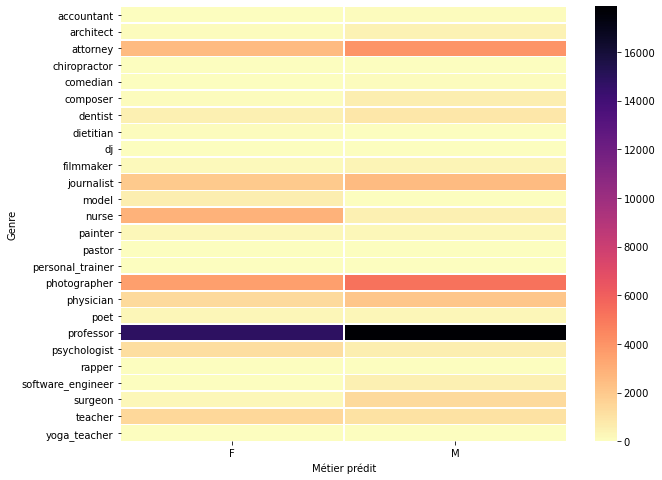

In [54]:
plot_heatmap(nb1_crossDispImp, "Genre", "Métier prédit", fmt='.2%')

In [55]:
nb1_avgDi = avgDi(nb1_crossDispImp)

--------------------------------
job: accountant
corresponding crosstab:
**************************************
gender          F      M
others      32629  39014
accountant     69     97
**************************************

disparate impact of accountant: 0.8508540829446362
--------------------------------
job: architect
corresponding crosstab:
**************************************
gender         F      M
others     32629  39014
architect    123    454
**************************************

disparate impact of architect: 0.32647997822105623
--------------------------------
job: attorney
corresponding crosstab:
**************************************
gender        F      M
others    32629  39014
attorney   2577   4021
**************************************

disparate impact of attorney: 0.7834034289361074
--------------------------------
job: chiropractor
corresponding crosstab:
**************************************
gender            F      M
others        32629  39014
chiropractor

<ipython-input-40-24b0addd4d1d>:11: RuntimeWarning: divide by zero encountered in double_scalars
  DI = (tab_np[1,0] / (tab_np[1,0] + tab_np[0,0])) / (tab_np[1,1] / (tab_np[1,1] + tab_np[0,1]))


In [56]:
print(f"Le disparate impact moyen associé à ce modèle de Naive bayes multinomial est de {nb1_avgDi}.")

Le disparate impact moyen associé à ce modèle de Naive bayes multinomial est de inf.


#### *************Commentaire*************

On note que ce modèle naive bayes multinomial permet d'avoir un disparate impact infini. Ce n'est pas aberrant lorsqu'on considère le heatmap de la cellule précédente. En efet on y constate que pour certains métiers tels que professeur de yoga n'ont eu aucun CV d'homme prédit comme tel. Ceci a bien évidemment des imapcts sur le disparate impact et donc sur le modèle.

In [57]:
pd.concat([logreg1_crossDispImp, nb1_crossDispImp], axis=1, keys=["logReg1", "Nb1"])

logReg1             Nb1         
gender                  F      M        F        M
accountant            277    520     69.0     97.0
architect             410   1189    123.0    454.0
attorney             2530   4020   2577.0   4021.0
chiropractor           63    207     10.0     14.0
comedian              105    320     34.0     92.0
composer              200    925    111.0    624.0
dentist               617   1099    519.0    880.0
dietitian             625     49    123.0      7.0
dj                     23    165      1.0      3.0
filmmaker             383    850    191.0    402.0
interior_designer     131     43      NaN      NaN
journalist           2286   2618   2007.0   2517.0
model                1041    213    608.0     38.0
nurse                3413    355   2925.0    510.0
painter               681    689    223.0    237.0
paralegal             113     24      NaN      NaN
pastor                100    259      7.0     12.0
personal_trainer       83     91      2.0      1.0
photographer         1973   3196   3563.0   5263.0
physician            1467   2205   1356.0   2154.0
poet                  633    599    346.0    295.0
professor           11103  14126  14820.0  17873.0
psychologist         1894   1132   1251.0    571.0
rapper                 14    163      2.0      6.0
software_engineer     148    997     47.0    508.0
surgeon               282   1603    268.0   1367.0
teacher              1793   1313   1444.0   1068.0
yoga_teacher          241     44      2.0      0.0

In [58]:
summary['Multinomial Naive Bayes'] = {
    "durée d'entrainement": tps1,
    "f1_score": nb1_f1_score,
    "disparate impact moyen" : nb1_avgDi
}

### Random forest 

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
rfc1 = RandomForestClassifier(n_estimators=200, max_depth=4, random_state=0, class_weight="balanced")
rfc1

RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=200,
                       random_state=0)

In [61]:
tps0=time.perf_counter()

rfc1.fit(X_train, y_train)

tps1=(time.perf_counter()-tps0)

print(f"temps d'entrainement: {tps1}")

temps d'entrainement: 8.159321892000008


In [62]:
import pickle
filename = "../../Project_outputs/pickled_files/models/random_forest/model_2_trained_with_round2_cleaned_corpus_for_models.pkl"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
pickle.dump(rfc1, open(filename, 'wb'))

In [63]:
rfc1_y_pred = rfc1.predict(X_test)
rfc1_y_pred

array(['attorney', 'surgeon', 'filmmaker', ..., 'journalist', 'professor',
       'filmmaker'], dtype=object)

In [64]:
print('accuracy %s' % accuracy_score(rfc1_y_pred, y_test))
print(classification_report(y_test, rfc1_y_pred, target_names=jobs))

accuracy 0.5511354912552517
                   precision    recall  f1-score   support

        professor       0.33      0.70      0.45      1050
       accountant       0.58      0.47      0.52      1918
        architect       0.78      0.68      0.73      6236
     psychologist       0.22      0.74      0.34       467
       journalist       0.41      0.72      0.52       566
          teacher       0.51      0.75      0.61      1161
            nurse       0.63      0.82      0.71      1790
         attorney       0.44      0.67      0.53       750
software_engineer       0.21      0.70      0.32       297
          painter       0.40      0.76      0.52      1344
        physician       0.14      0.76      0.23       282
     chiropractor       0.41      0.51      0.46      4085
 personal_trainer       0.45      0.48      0.47      1397
     photographer       0.64      0.76      0.69      4134
          surgeon       0.52      0.74      0.61      1463
        filmmaker       0.1

#### f1_score

In [65]:
rfc1_f1_score = f1_score(y_test, rfc1_y_pred, average='macro')
print('f1_score: %s' % rfc1_f1_score)

f1_score: 0.47514797096765654


#### Disparate impact

In [66]:
rfc1_crossDispImp = dispImpContTable(y_test, rfc1_y_pred, data1)
rfc1_crossDispImp

gender                F     M
predicted_job                
accountant          823  1408
architect           450  1084
attorney           2213  3265
chiropractor        758   793
comedian            360   633
composer            484  1236
dentist             939  1405
dietitian           897   257
dj                  344   643
filmmaker          1015  1566
interior_designer   712   830
journalist         2339  2710
model               929   553
nurse              3891   984
painter            1024  1044
paralegal           619   685
pastor              457   889
personal_trainer    714   598
photographer       1370  2264
physician          1198  1771
poet               1346  1390
professor          4745  6181
psychologist       1274   758
rapper              192   417
software_engineer   550  1590
surgeon            1294  2905
teacher             988   762
yoga_teacher        704   393

In [67]:
rfc1_avgDi = avgDi(rfc1_crossDispImp)

--------------------------------
job: accountant
corresponding crosstab:
**************************************
gender          F      M
others      32629  39014
accountant    823   1408
**************************************

disparate impact of accountant: 0.7063059910129031
--------------------------------
job: architect
corresponding crosstab:
**************************************
gender         F      M
others     32629  39014
architect    450   1084
**************************************

disparate impact of architect: 0.5032149916408322
--------------------------------
job: attorney
corresponding crosstab:
**************************************
gender        F      M
others    32629  39014
attorney   2213   3265
**************************************

disparate impact of attorney: 0.8224696074943612
--------------------------------
job: chiropractor
corresponding crosstab:
**************************************
gender            F      M
others        32629  39014
chiropractor 

In [68]:
print(f"Le disparate impact moyen associé à ce modèle de forêt aléatoire est de {rfc1_avgDi}.")

Le disparate impact moyen associé à ce modèle de forêt aléatoire est de 1.2172032313566912.


#### *************Commentaire*************

Avec le random forest on obtient un disparate impact moyen de 1.55 environ. En d'autres termes ce modèle est le plus "juste", le plus "loyal" selon le genre de l'individu à qui appartient le CV.

In [69]:
pd.concat([logreg1_crossDispImp, nb1_crossDispImp, rfc1_crossDispImp], axis=1, keys=["logReg1", "Naive bayes", "random forest"])

logReg1        Naive bayes          random forest      
gender                  F      M           F        M             F     M
accountant            277    520        69.0     97.0           823  1408
architect             410   1189       123.0    454.0           450  1084
attorney             2530   4020      2577.0   4021.0          2213  3265
chiropractor           63    207        10.0     14.0           758   793
comedian              105    320        34.0     92.0           360   633
composer              200    925       111.0    624.0           484  1236
dentist               617   1099       519.0    880.0           939  1405
dietitian             625     49       123.0      7.0           897   257
dj                     23    165         1.0      3.0           344   643
filmmaker             383    850       191.0    402.0          1015  1566
interior_designer     131     43         NaN      NaN           712   830
journalist           2286   2618      2007.0   2517.0          2339  2710
model                1041    213       608.0     38.0           929   553
nurse                3413    355      2925.0    510.0          3891   984
painter               681    689       223.0    237.0          1024  1044
paralegal             113     24         NaN      NaN           619   685
pastor                100    259         7.0     12.0           457   889
personal_trainer       83     91         2.0      1.0           714   598
photographer         1973   3196      3563.0   5263.0          1370  2264
physician            1467   2205      1356.0   2154.0          1198  1771
poet                  633    599       346.0    295.0          1346  1390
professor           11103  14126     14820.0  17873.0          4745  6181
psychologist         1894   1132      1251.0    571.0          1274   758
rapper                 14    163         2.0      6.0           192   417
software_engineer     148    997        47.0    508.0           550  1590
surgeon               282   1603       268.0   1367.0          1294  2905
teacher              1793   1313      1444.0   1068.0           988   762
yoga_teacher          241     44         2.0      0.0           704   393

In [70]:
summary['Random Forest'] = {
    "durée d'entrainement": tps1,
    "f1_score": rfc1_f1_score,
    "disparate impact moyen" : rfc1_avgDi
}

### Linear Support Vector Machine

In [71]:
from sklearn.svm import LinearSVC

In [72]:
lsvc1 = LinearSVC(random_state=0, class_weight="balanced", max_iter=2000)
lsvc1

LinearSVC(class_weight='balanced', max_iter=2000, random_state=0)

In [73]:
tps0=time.perf_counter()

lsvc1.fit(X_train, y_train)

tps1=(time.perf_counter()-tps0)

print(f"temps d'entrainement: {tps1}")

temps d'entrainement: 34.471732970999966


In [74]:
import pickle
filename = "../../Project_outputs/pickled_files/models/linear_support_vector_machine/model_2_trained_with_round2_cleaned_corpus_for_models.pkl"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
pickle.dump(lsvc1, open(filename, 'wb'))

In [75]:
lsvc1_y_pred = lsvc1.predict(X_test)
lsvc1_y_pred

array(['attorney', 'professor', 'yoga_teacher', ..., 'journalist',
       'professor', 'filmmaker'], dtype=object)

In [76]:
print('accuracy %s' % accuracy_score(lsvc1_y_pred, y_test))
print(classification_report(y_test, lsvc1_y_pred, target_names=jobs))

accuracy 0.7755956618232067
                   precision    recall  f1-score   support

        professor       0.64      0.74      0.69      1050
       accountant       0.59      0.64      0.61      1918
        architect       0.87      0.87      0.87      6236
     psychologist       0.59      0.69      0.64       467
       journalist       0.64      0.73      0.68       566
          teacher       0.75      0.83      0.79      1161
            nurse       0.89      0.93      0.91      1790
         attorney       0.72      0.84      0.77       750
software_engineer       0.69      0.67      0.68       297
          painter       0.69      0.78      0.73      1344
        physician       0.55      0.69      0.61       282
     chiropractor       0.67      0.72      0.70      4085
 personal_trainer       0.67      0.76      0.71      1397
     photographer       0.85      0.81      0.83      4134
          surgeon       0.70      0.82      0.76      1463
        filmmaker       0.6

#### f1_score

In [77]:
lsvc1_f1_score = f1_score(y_test, lsvc1_y_pred, average='macro')
print('f1_score: %s' % lsvc1_f1_score)

f1_score: 0.7074423749806932


#### Disparate impact

In [78]:
lsvc1_crossDispImp = dispImpContTable(y_test, lsvc1_y_pred, data1)
lsvc1_crossDispImp

gender                F      M
predicted_job                 
accountant          432    794
architect           571   1493
attorney           2426   3833
chiropractor        167    378
comedian            174    469
composer            251   1039
dentist             693   1180
dietitian           767    110
dj                   52    235
filmmaker           523   1017
interior_designer   246    105
journalist         2046   2318
model              1198    372
nurse              3511    423
painter             847    863
paralegal           214     72
pastor              243    517
personal_trainer    155    152
photographer       1763   2910
physician          1597   2289
poet                868    867
professor          8833  11177
psychologist       2199   1412
rapper               48    225
software_engineer   256   1337
surgeon             439   1981
teacher            1789   1361
yoga_teacher        321     85

In [79]:
lsvc1_avgDi = avgDi(lsvc1_crossDispImp)

--------------------------------
job: accountant
corresponding crosstab:
**************************************
gender          F      M
others      32629  39014
accountant    432    794
**************************************

disparate impact of accountant: 0.6551151116206309
--------------------------------
job: architect
corresponding crosstab:
**************************************
gender         F      M
others     32629  39014
architect    571   1493
**************************************

disparate impact of architect: 0.4666253157304368
--------------------------------
job: attorney
corresponding crosstab:
**************************************
gender        F      M
others    32629  39014
attorney   2426   3833
**************************************

disparate impact of attorney: 0.7736106241010781
--------------------------------
job: chiropractor
corresponding crosstab:
**************************************
gender            F      M
others        32629  39014
chiropractor 

In [80]:
print(f"Le disparate impact moyen associé à ce modèle de linear support vector machine est de {lsvc1_avgDi}.")

Le disparate impact moyen associé à ce modèle de linear support vector machine est de 1.7283331965822033.


In [81]:
pd.concat([logreg1_crossDispImp, nb1_crossDispImp, rfc1_crossDispImp, lsvc1_crossDispImp], axis=1, keys=["logistic regression", "Naive bayes", "random forest", "linear support vector machine"])

logistic regression        Naive bayes           \
gender                              F      M           F        M   
accountant                        277    520        69.0     97.0   
architect                         410   1189       123.0    454.0   
attorney                         2530   4020      2577.0   4021.0   
chiropractor                       63    207        10.0     14.0   
comedian                          105    320        34.0     92.0   
composer                          200    925       111.0    624.0   
dentist                           617   1099       519.0    880.0   
dietitian                         625     49       123.0      7.0   
dj                                 23    165         1.0      3.0   
filmmaker                         383    850       191.0    402.0   
interior_designer                 131     43         NaN      NaN   
journalist                       2286   2618      2007.0   2517.0   
model                            1041    213       608.0     38.0   
nurse                            3413    355      2925.0    510.0   
painter                           681    689       223.0    237.0   
paralegal                         113     24         NaN      NaN   
pastor                            100    259         7.0     12.0   
personal_trainer                   83     91         2.0      1.0   
photographer                     1973   3196      3563.0   5263.0   
physician                        1467   2205      1356.0   2154.0   
poet                              633    599       346.0    295.0   
professor                       11103  14126     14820.0  17873.0   
psychologist                     1894   1132      1251.0    571.0   
rapper                             14    163         2.0      6.0   
software_engineer                 148    997        47.0    508.0   
surgeon                           282   1603       268.0   1367.0   
teacher                          1793   1313      1444.0   1068.0   
yoga_teacher                      241     44         2.0      0.0   

                  random forest       linear support vector machine         
gender                        F     M                             F      M  
accountant                  823  1408                           432    794  
architect                   450  1084                           571   1493  
attorney                   2213  3265                          2426   3833  
chiropractor                758   793                           167    378  
comedian                    360   633                           174    469  
composer                    484  1236                           251   1039  
dentist                     939  1405                           693   1180  
dietitian                   897   257                           767    110  
dj                          344   643                            52    235  
filmmaker                  1015  1566                           523   1017  
interior_designer           712   830                           246    105  
journalist                 2339  2710                          2046   2318  
model                       929   553                          1198    372  
nurse                      3891   984                          3511    423  
painter                    1024  1044                           847    863  
paralegal                   619   685                           214     72  
pastor                      457   889                           243    517  
personal_trainer            714   598                           155    152  
photographer               1370  2264                          1763   2910  
physician                  1198  1771                          1597   2289  
poet                       1346  1390                           868    867  
professor                  4745  6181                          8833  11177  
psychologist               1274   758                          2199   1412  
rapper                

In [82]:
lsvc1_f1_score = f1_score(y_test, lsvc1_y_pred, average='macro')
print('f1_score: %s' % lsvc1_f1_score)

f1_score: 0.7074423749806932


In [83]:
summary['Linear Support Vector Machine'] = {
    "durée d'entrainement": tps1,
    "f1_score": lsvc1_f1_score,
    "disparate impact moyen" : lsvc1_avgDi
}

## Récapitulatif

In [84]:
summary

{'logisitic regression': {"durée d'entrainement": 183.802625066,
  'f1_score': 0.7279625670077278,
  'disparate impact moyen': 2.2416012959147666},
 'Multinomial Naive Bayes': {"durée d'entrainement": 0.6567064090000088,
  'f1_score': 0.3952169028078666,
  'disparate impact moyen': inf},
 'Random Forest': {"durée d'entrainement": 8.159321892000008,
  'f1_score': 0.47514797096765654,
  'disparate impact moyen': 1.2172032313566912},
 'Linear Support Vector Machine': {"durée d'entrainement": 34.471732970999966,
  'f1_score': 0.7074423749806932,
  'disparate impact moyen': 1.7283331965822033}}

In [85]:
df_summary = pd.DataFrame(summary)
df_summary

logisitic regression  Multinomial Naive Bayes  \
durée d'entrainement              183.802625                 0.656706   
f1_score                            0.727963                 0.395217   
disparate impact moyen              2.241601                      inf   

                        Random Forest  Linear Support Vector Machine  
durée d'entrainement         8.159322                      34.471733  
f1_score                     0.475148                       0.707442  
disparate impact moyen       1.217203                       1.728333

In [86]:
filename = "../../Project_outputs/csv_files/round2_models_summary.csv"
if not os.path.exists(filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
df_summary.to_csv(filename, index=True,header=True)